# Fire Segmentation

## Initializations

In [1]:
# Import libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Segmentation

In [2]:
def low_light(image):
    # Convert to HSV
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Apply histogram equalization to V channel
    hsv[:, :, 2] = cv.equalizeHist(hsv[:, :, 2])

    # Apply median filter to V channel
    hsv[:, :, 2] = cv.medianBlur(hsv[:, :, 2], 5)

    # Convert back to RGB
    img = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    return img

In [33]:
def ycbcr_mean(image):
    img = image.copy()

    # Convert to YCbCr
    ycbcr = cv.cvtColor(image, cv.COLOR_BGR2YCrCb)

    # Split channels
    y, cb, cr = cv.split(ycbcr)

    # Define rules
    mask = (y >= 170) | (y < 145) & (cb <= 120) & (cb >= 50) & (cr > 120) & (cr < 220)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    return img

In [34]:
def rgb_space(image):
    img = image.copy()

    # Split channels
    b, g, r = cv.split(image)

    # Define rules
    rules = [
        r > g,
        g > b,
        r > 190,
        g > 90,
        b < 140,
        0.1 <= (g/(r+1)),
        (g/(r+1)) <= 1,
        0.1 <= (b/(r+1)),
        (b/(r+1)) <= 0.85,
        0.1 <= (b/(g+1)),
        (b/(g+1)) <= 0.85
    ]

    # Apply rules
    mask = np.all(rules, axis=0)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    # Apply morphological operations
    kernel = np.ones((3, 3), np.uint8)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)

    return img

In [35]:
# Get percentage from 2 images spatially
def get_percentage(img1, img2):
    # Convert to grayscale
    img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

    # Get percentage of white pixels location
    percentage = np.sum(img1 == img2) / (img1.shape[0] * img1.shape[1])

    return percentage

In [52]:
def segment(img_path):
    # Specify image path
    img = cv.imread(img_path)

    # Low light
    low_light_img = low_light(img)

    # RGB Rules
    rgb_space_img = rgb_space(img)
    rgb_space_low_light = rgb_space(low_light_img)

    # YCbCr Rules
    ycbcr_img = ycbcr_mean(img)
    ycbcr_low_light = ycbcr_mean(low_light_img)

    # Combine: RGB Rules + YCbCr Rules
    combined_img = cv.bitwise_or(rgb_space_img, ycbcr_img) 
    combined_img_low = cv.bitwise_or(rgb_space_low_light, ycbcr_low_light)

    # Ultimate combine: Combined original + Combined low light
    ultimate_combined = cv.bitwise_and(combined_img, combined_img_low)

    # RGB combine: RGB Rules + RGB Rules Low Light
    rgb_combined = cv.bitwise_or(rgb_space_img, rgb_space_low_light)

    # Calculate percentage
    print('Percentage of Ultimate Combined and RGB Combined: ', get_percentage(ultimate_combined, rgb_combined))

    # Define images and titles
    images = [
        img,
        low_light_img,
        rgb_space_img,
        rgb_space_low_light,
        ycbcr_img,
        ycbcr_low_light,
        combined_img,
        combined_img_low,
        ultimate_combined,
        rgb_combined
    ]

    titles = [
        'Original',
        'Low Light',
        'RGB Rules',
        'RGB Rules Low Light',
        'YCbCr Rules',
        'YCbCr Rules Low Light',
        'Original Combined',
        'Low Light Combined',
        'Ultimate Combined',
        'RGB Combined',
    ]

    plt.figure(figsize=(4, 20))
    for i in range(len(images)):
        plt.subplot(10, 2, i+1)
        plt.imshow(images[i][:, :, ::-1])
        plt.title(titles[i])
        plt.axis('off')
    # plt.savefig('segment.png')
    plt.show()

## Results

C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:14: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (g/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:15: RuntimeWarning: divide by zero encountered in divide
  (g/(r+1)) <= 1,
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:16: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (b/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:17: RuntimeWarning: divide by zero encountered in divide
  (b/(r+1)) <= 0.85,


Percentage of Ultimate Combined and RGB Combined:  0.8128157272614159


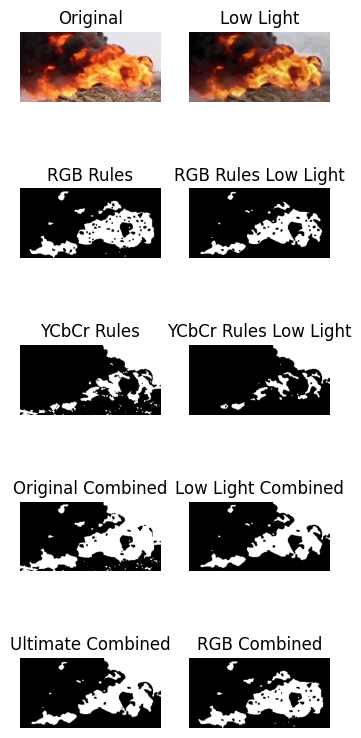

In [53]:
# High Percentage Similarity
segment('./test/1.jpg')

High percentage comparison uses the RGB combined as the end result

C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:14: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (g/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:15: RuntimeWarning: divide by zero encountered in divide
  (g/(r+1)) <= 1,
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:16: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (b/(r+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:17: RuntimeWarning: divide by zero encountered in divide
  (b/(r+1)) <= 0.85,
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:18: RuntimeWarning: divide by zero encountered in divide
  0.1 <= (b/(g+1)),
C:\Users\dikib\AppData\Local\Temp\ipykernel_22064\2934558068.py:19: RuntimeWarning: divide by zero encountered in divide
  (b/(g+1)) <= 0.85


Percentage of Ultimate Combined and RGB Combined:  0.2352533924120742


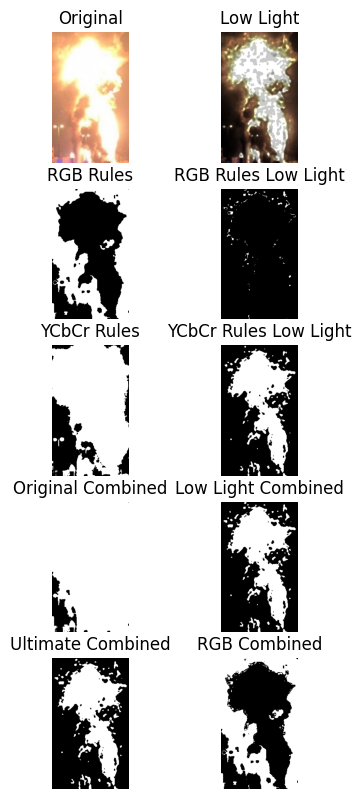

In [54]:
# Low Percentage Similarity
segment('./test/2.jpg')